In [1]:
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
import scipy


## Convenience functions

Usually we can assume the arrival rate $a$ is unity.

In [2]:
def decode_xy_tele_1d(x, y, mu_N, kon=1):
    theta = kon*x/(1-x)
    B = kon*theta/mu_N
    koff = -np.sqrt((y-1)**2 *kon**2 - 4*B*(y-1)*y)/(2*(y-1))-kon/2
    kappa = kon+koff
    alpha = theta*kappa/koff
    beta = B/koff
    return kon,koff,alpha,beta
def encode_xy_tele_1d(kon,koff,alpha,beta):
    kappa = kon+koff
    theta = koff*alpha/kappa
    mu_K = kon*alpha/kappa
    mu_N = mu_K/beta
    x = theta/(theta+kon)
    y = kappa/(kappa+beta)
    return x,y,mu_N,kon

In [3]:
def decode_xy_sde_1d(x, y, mu_N, a = 1):
    kon,koff,alpha,beta = decode_xy_tele_1d(x, y, mu_N, a)
    kappa = kon+koff
#     print(kappa)
    theta = koff*alpha/kappa
    B = kon*theta/mu_N
#     beta = B/koff
    return a, kappa, theta, beta

def encode_xy_sde_1d(a, kappa, theta,beta):
    mu_K = a*theta/kappa
    mu_N = mu_K/beta
    x = theta/(theta+a)
    y = kappa/(beta+kappa)
    return x,y,mu_N,a

In [4]:
a = 1
kappa = 2
theta = 10
beta = 0.1

In [5]:
decode_xy_sde_1d(*encode_xy_sde_1d(a, kappa, theta,beta))

(1, 2.561552812808829, 9.999999999999996, 0.12807764064044158)

In [6]:
encode_xy_sde_1d(a, kappa, theta,beta)

(0.9090909090909091, 0.9523809523809523, 50.0, 1)

### The switching model

In [144]:
class TelegraphModel():
    """
    This collection of convenience functions is placed in its own class mostly to avoid function name conflicts.
    The code is largely reused from "Transient and delay chemical master equations".
    """
    def __init__(self):
        pass
    def setup(self,N,n,K_val,A_val,beta_val,gamma_val):
        H = np.zeros((N,N))
        for kv in K_val:
            H[kv[0],kv[1]] = kv[2]
        H -= np.diag(H.sum(1))

        A = np.zeros((N,n))
        for av in A_val:
            A[av[0],av[1]-1] = av[2]

        B = np.zeros((n,n))
        for bv in beta_val:
            B[bv[0]-1,bv[1]-1] = bv[2]
        B -= np.diag(B.sum(1))
        for gv in gamma_val:
            B[gv[0]-1,gv[0]-1] -= gv[1]

        Nspec = N+n
        Nrxn = len(K_val) + len(A_val) + len(gamma_val) + len(beta_val)
        Hss = scipy.linalg.null_space(H.T)
        Hss /= Hss.sum()
        Hss = Hss.squeeze()
        return H,A,B,Hss

    def get_g(self,limits):
        u = []
        mx = np.copy(limits)
        mx[-1] = mx[-1] // 2 + 1

        for i in range(len(mx)):
            l = np.arange(mx[i])
            u_ = np.exp(-2j*np.pi*l/limits[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()
        return np.asarray(g).T,mx

    def compute_coeff(self,L,V,Vinv,u,j=0):
        n_u = u.shape[1]
        a = np.asarray([(V@np.diag( Vinv @ u[:,i]))[j] for i in range(n_u)]).T
        return a

    def compute_eigs(self,C):
        L,V = np.linalg.eig(C)
        Vinv = np.linalg.inv(V)
        return L,V,Vinv

    def pss_wrapper(self,H,A,C,t,mx,n,N,initcond):
        g,mx_red = self.get_g(mx)
        L,V,Vinv = self.compute_eigs(C)
        coeff = np.asarray([self.compute_coeff(L,V,Vinv,g.T,i) for i in range(n)])

        if initcond[0][0]=='thermalized':
            Hfin = scipy.linalg.null_space(H.T)
            Hfin /= Hfin.sum()
            w = Hfin.squeeze()
        elif initcond[0][0]=='deterministic':
            w = np.zeros(N)
            w[initcond[0][1]] = 1
        elif initcond[0][0]=='categorical':
            w = initcond[0][1]
        else:
            raise ValueError('Not implemented')
        w = np.asarray(w,dtype=np.complex128)

        gf_initcond_prop = np.matlib.repmat(w,g.shape[0],1).astype(np.complex128)
        gf = self.gfun_numerical(g,t,H,A,N,L,coeff,gf_initcond_prop)
        gf = np.reshape(gf,np.concatenate((mx_red,[N])).astype(int))
        Pss = scipy.fft.irfftn(gf,axes=[0,1],s=mx)
        return Pss

    def gfun_numerical(self,g,t,H,A,N,L,coeff,gf_initcond):
        gf_ = np.zeros((g.shape[0],N),dtype=np.complex128)

        for i in (range(g.shape[0])):
            t0 = 0
            y0 = gf_initcond[i]

            Ufun = lambda x: np.asarray([self.ufun_generic(x,L,coef[:,i]) for coef in coeff])
            intfun = lambda t,y: self.intfun_multi(t,y,H,A,Ufun)
            res = scipy.integrate.solve_ivp(intfun,[t,t0],y0)
            while res.status == 'running':
                res.step()
            gf_[i] = res.y[:,-1]
        return gf_

    def ufun_generic(self,x,L,coeff):
        Ufun = (np.exp(L*x)@coeff)
        return Ufun

    def intfun_multi(self,t,y,H,A,Ufun):
        dy = np.dot(H.T,y) + np.dot(A,Ufun(t))*y
        return -dy

    def get_Pss(self,kon,koff,kinit,beta,gamma,mx):
        N = 2
        K_val = [[0,1,kon],
                 [1,0,koff]]

        n = 2
        A_val =[[1,1,kinit]]

        gamma_val = [[2,gamma]]
        beta_val = [[1,2,beta]]

        initcond = [['thermalized'],
                ['deterministic',0],
                ['deterministic',0]]
        t = 10/np.min([kon,koff,beta,gamma,kinit])
        H,A,C,Hss = self.setup(N,n,K_val,A_val,beta_val,gamma_val)
        Pss = self.pss_wrapper(H,A,C,t,mx,n,N,initcond)
#         print(Pss.shape)
        return Pss.sum(2)


In [145]:
kon = 0.9
koff = 0.1
kinit = 5
beta = 1.2
gamma = 0.7
mx = [50,1]

In [146]:
kinit*kon/(kon+koff)/beta

3.75

In [151]:
# kinit/beta

In [152]:
telegraph_model = TelegraphModel()
Pss_tele = telegraph_model.get_Pss(kon,koff,kinit,beta,gamma,mx)

In [153]:
x = np.arange(mx[0])

In [154]:
(Pss_tele.sum(1)*x).sum()

3.747550603041915

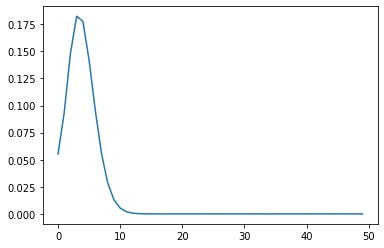

In [155]:
plt.plot(Pss_tele.sum(1))

### Gamma-OU

In [156]:
class GOUModel():
    """
    This collection of convenience functions is largely reused from 
    "Interpretable and tractable models of transcriptional noise for the 
    rational design of single-molecule quantification experiments".
    """
    def __init__(self):
        pass
    def get_GOU_2sp(self,mx, params):
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))

        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
        Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
        return Pss

    def get_gf_GOU_2sp_ODE(self,g0, g1, params):
        beta_0, beta_1, a, kappa, theta = params     # get parameters

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

        min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
        t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
        num_tsteps = int(np.ceil(t_max/dt))
        t_array = np.linspace(0, t_max, num_tsteps+1)
        t_array = t_array.reshape((1, num_tsteps + 1))

        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
        c0 = c0.reshape((c0.shape[0],1))
        c1 = c1.reshape((c1.shape[0],1))
        q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
        q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
        q = q0 + q1


        integrand = q/(1-q)
        integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
        gf = np.exp( a*integral)               # get generating function
        return gf
    
    def get_Pss(self,a,kappa,theta,beta,gamma,mx):
        params = beta, gamma, a, kappa, theta
        Pss = self.get_GOU_2sp(mx, params)
        return Pss

In [176]:
a = kon
kappa = kon+koff
theta = koff*kinit/kappa


In [178]:
gou_model = GOUModel()
Pss_gou = gou_model.get_Pss(a,kappa,theta,beta,gamma,mx)

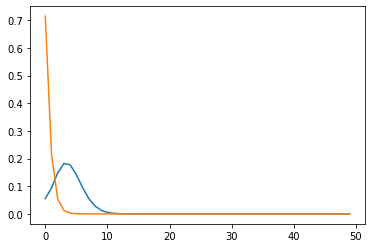

In [179]:
plt.plot(Pss_tele.sum(1))
plt.plot(Pss_gou.sum(1))

### CIR 

In [191]:
class CIRModel():
    """
    This collection of convenience functions is largely reused from 
    "Interpretable and tractable models of transcriptional noise for the 
    rational design of single-molecule quantification experiments".
    """
    def __init__(self):
        pass
    # ODE for 2 species CIR model
    def f_2sp(self,q, t, c0, c1, params):
        beta_0, beta_1, a, kappa, theta = params
        result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
        return result


    # Vectorized RK4 implementation for 2 species CIR model
    def RK4_2sp(self,q, f, t, c0, c1, step_size, param):
        j1 = f(q, t, c0, c1, param)
        j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
        j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
        j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  

        q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
        return q_new


    # Get 2 species CIR generating function using ODE method
    def get_gf_CIR_2sp(self,g0, g1, params):
        beta_0, beta_1, a, kappa, theta = params     # get parameters

        c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
        c1 = - (beta_0/(beta_1 - beta_0))*(g1)   

        min_fudge, max_fudge = 0.25, 10                                     # Determine integration time scale / length
        dt = np.min([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*min_fudge
        t_max = np.max([1/kappa, 1/theta, 1/a, 1/beta_0, 1/beta_1])*max_fudge
        num_tsteps = int(np.ceil(t_max/dt))

        q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE

        # Solve ODE using RK4 method 
        for i in range(0, num_tsteps):
            t = i*dt
            q[:,i+1] = self.RK4_2sp(q[:,i], self.f_2sp, t, c0, c1, dt, params)

        integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
        gf = np.exp((a*theta/kappa)*integral)               # get generating function
        return gf


    # Get Pss for 2 species CIR model via ODE method
    def get_CIR_2sp(self,mx,params):
        # Get generating function argument
        u = []
        half = mx[:]
        half[-1] = mx[-1]//2 + 1
        for i in range(len(mx)):
            l = np.arange(half[i])
            u_ = np.exp(-2j*np.pi*l/mx[i])-1
            u.append(u_)
        g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
        for i in range(len(mx)):
            g[i] = g[i].flatten()

        # Get generating function
        gf = self.get_gf_CIR_2sp(g[0], g[1], params)                    
        gf = gf.reshape(tuple(half))

        Pss = scipy.fft.irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
        Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
        return Pss

    def get_Pss(self,a,kappa,theta,beta,gamma,mx):
        params = beta, gamma, a, kappa, theta
        Pss = self.get_CIR_2sp(mx, params)
        return Pss

In [199]:
a = 0.5
kappa = 1
theta = 6

In [200]:
gou_model = GOUModel()
Pss_gou = gou_model.get_Pss(a,kappa,theta,beta,gamma,mx)
cir_model = CIRModel()
Pss_cir = cir_model.get_Pss(a,kappa,theta,beta,gamma,mx)

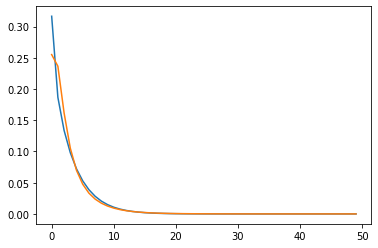

In [201]:
plt.plot(Pss_gou)
plt.plot(Pss_cir)